In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/cs7643
import sys
sys.path.append('/content/drive/MyDrive/cs7643')
!pip install mlflow skorch
# !pip install Ipython --upgrade
%cd /content/drive/MyDrive/cs7643

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Copy of run3.ipynb'	 __pycache__			   run6.ipynb
 data			 run10_selfatt_final_mnist.ipynb   run7.ipynb
 experiment_configs.py	 run1.ipynb			   run8_selfatt_unweighted.ipynb
 mlruns			 run2.ipynb			   run9_selfatt_final.ipynb
 models			 run3.ipynb			   satt-final-mnist.ipynb
 pipeline_template.py	 run4.ipynb
 plots			 run5.ipynb
/content/drive/MyDrive/cs7643


In [3]:
%ls models

attention/        original_basic_block.py  resnet_multi_head_att.py       squeezenet.py
cbamBlock.py      original_basic_block.py    resnet_self_att_mnist.py       vgg16-imagenet.py
cifar10resnet.py  __pycache__/             resnet_self_att.py
mnistresnet.py    resnet_cbam.py           resnet_self_att_unweighted.py


In [4]:
import pipeline_template, mlflow, torch, torchvision
from experiment_configs import configs, ExperimentConfig, ModelConfig, DataConfig
from models.mnistresnet import MNISTResNet
from models.cifar10resnet import Cifar10ResNet
from models.original_basic_block import OriginalBasicBlock
from skorch.callbacks import LRScheduler
from skorch.dataset import ValidSplit
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.transforms import transforms
mlflow.set_tracking_uri('file:/content/drive/MyDrive/cs7643/mlruns')

In [10]:
def _get_cifar10_original_paper_evaluation_config(experiment_name, model) -> ExperimentConfig:
    # see https://github.com/a-martyn/resnet/blob/master/main.ipynb
    means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
    stds = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

    iterations_per_epoch = 45000 // 128 # == 351
    return ExperimentConfig(
        experiment_name,
        data_config=DataConfig(
            name='MNIST',
            # Quote: "which consists of 50k training images and 10k test images"
            test_size=10000,
            # Quote 1: "The network inputs are 32x32 images, with the per-pixel mean subtracted"
            # Quote 2: "We follow the simple data augmentation in [24] for training:
            # 4 pixels are padded on each side, and a 32x32 is randomly sampled
            # from the padded image or its horizontal flip."
            train_transform=transforms.Compose([
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomCrop(32, padding=4),
                transforms.ToTensor(),
                # transforms.Normalize(mean=means, std=stds)
            ]),
            # Quote 1: "The network inputs are 32x32 images, with the per-pixel mean subtracted"
            # Quote 2: "For testing, we only evaluate the single view of the original 32x32 image".
            test_transform=transforms.Compose([
                transforms.ToTensor(),
                # transforms.Normalize(mean=means, std=stds)
            ])

        ),
        model_config=ModelConfig(
            model=model,
            # Quote: "We start with a learning rate of 0.1
            lr=0.1,
            # I think it is SGD, as they use momentum
            optimizer=torch.optim.SGD,
            # Quote: "These models are trained with mini-batch size of 128"
            batch_size=128,
            # Quote: "terminate training at 64k iterations which is determined on a 45k/5k train/val split"
            max_epochs=64000 // iterations_per_epoch, # == 182
            # Quote: "We use a weight decay of 0.0001"
            weight_decay=0.0001,
            # Quote: "and momentum of 0.9"
            momentum=0.9,
            # Quote: "We present experiments trained on the training set and evaluated on the test set."
            # Note: They likely tuned on 45k/5k train/val split, but evaluated on the training set (this is why default is None)
            train_split=None,
            # Quote: "divide it by 10 at 32k and 48k iterations [...] which is determined on a 45k/5k train/val split"
            scheduler=LRScheduler(
                policy=MultiStepLR,
                milestones=[
                    32000 // iterations_per_epoch, # == 91
                    48000 // iterations_per_epoch # == 136
                ],
                gamma=0.1 # this is the multiplication factor ("divide it by 10")
            ),
            add_test_set_eval=True,
            log_model=True,
            early_stopping_params={
                        'patience': 10,
                        'threshold': 0.001,
                        'threshold_mode': 'rel'
                    },
            use_early_stopping=True,
        )
    )

RANDOM_VAR = 10

def _get_cifar10_original_paper_training_config(experiment_name, model) -> ExperimentConfig:
    config = _get_cifar10_original_paper_evaluation_config(experiment_name, model)
    config.model_config.train_split = ValidSplit(0.1, random_state=RANDOM_VAR)
    config.model_config.add_test_set_eval = False
    return config


configs = { # mapping keys to lambdas to ensure that the configs are only loaded upon request. Otherwise, the seed may not be applied and we get non-determinstic results!
    "mnist_resnet20_original_paper": lambda: _get_cifar10_original_paper_evaluation_config(
        "MNIST ResNet20",
        MNISTResNet(
            OriginalBasicBlock,
            [3, 3, 3],
            10)
    )
}

NoneType: None


=== Model Details ===
MNISTResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): OriginalBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (1): OriginalBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 

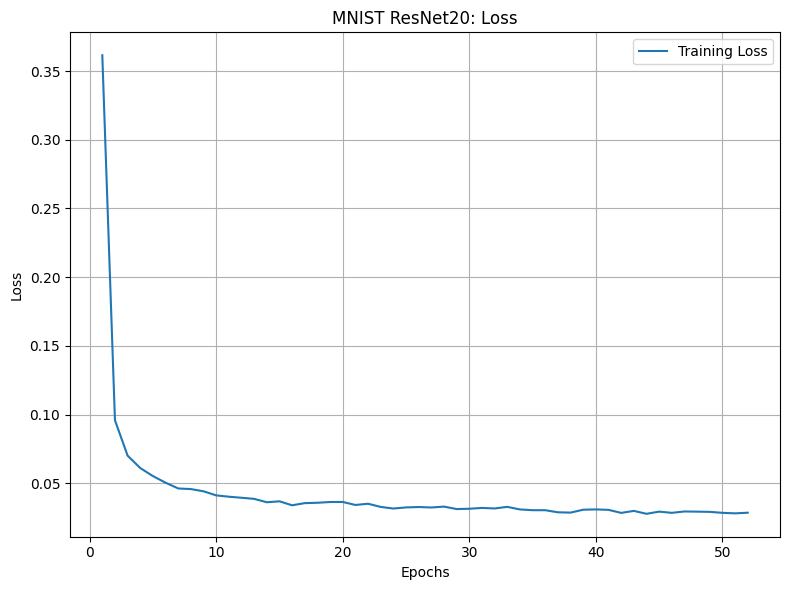

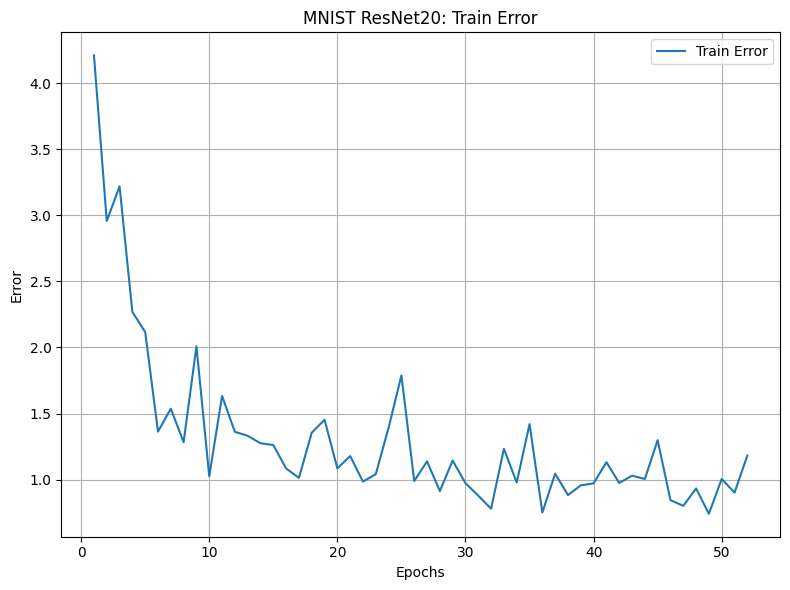

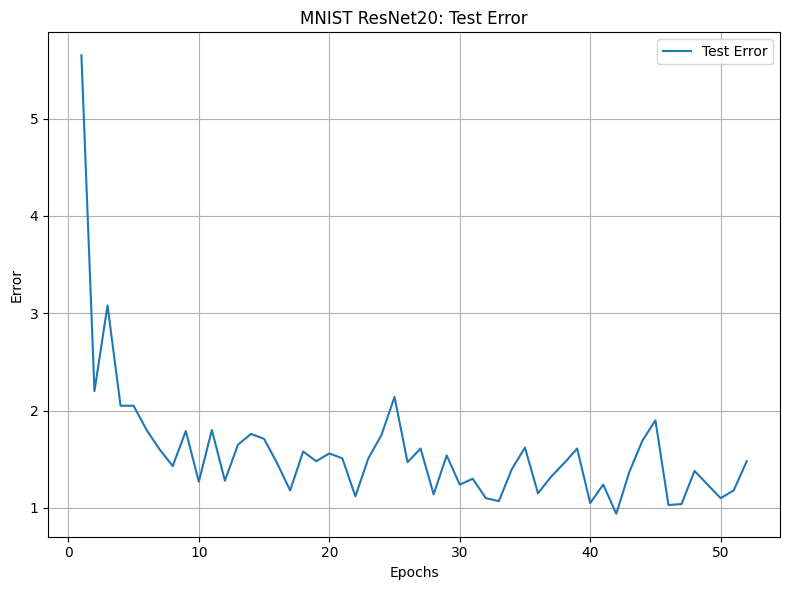

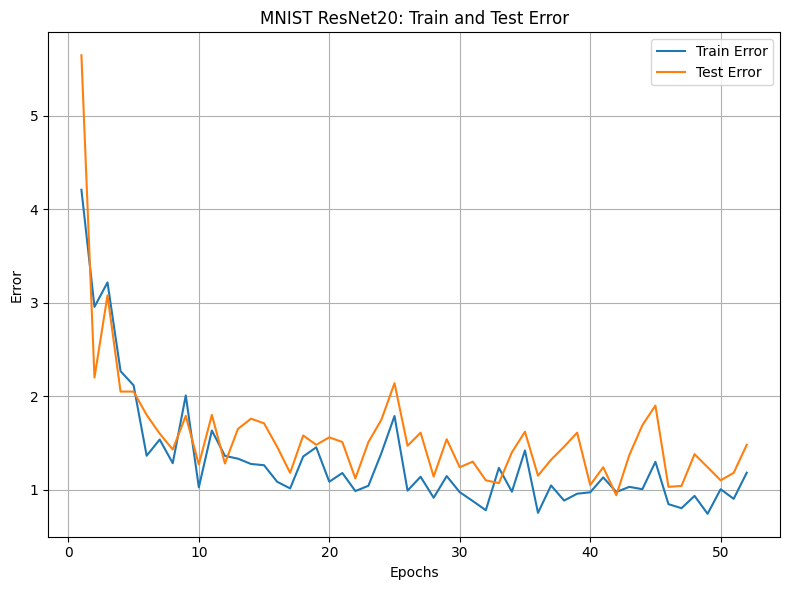

2024/12/08 15:24:37 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/08 15:24:45 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/08 15:24:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [11]:
pipeline_template.main('mnist_resnet20_original_paper', True, configs)
# pipeline_template.main('debug_config')